In [22]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import math
from torch.autograd import Variable
import seaborn as sns

# Transformers 


**Credits:** In this notebook you are going to use a Transformer model as described in the ["Attention is all you need"](https://arxiv.org/pdf/1706.03762.pdf) paper. This notebook closely follows the PyTorch tutorial on [language translation using Transformers](https://pytorch.org/tutorials/beginner/translation_transformer.html) but we will try to incorporate information from the [Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html), i.e. a nice description of the model presented in the paper by a professor from Harvard. If you are really interested in using transformers we really suggest you to go through the Annotated Transformer blog. Other interesting read for understand this model that are also partially used to build this notebook are: [This blog post](https://e2eml.school/transformers.html) and this [twitter thread](https://threadreaderapp.com/thread/1470406419786698761.html).

For this notebook, we are providing a trained model, so you are not required to train anything, although we will give you the code to train a model. The main goal is to explain in-detail supported by a small code-snipet each 

**NOTE**: This notebook is far from being perfect since it was a "last-minute addition" and mostly because I am still learning about transformers and how to work with text while preparing this notebook. However, I wanted to give you a small introduction and example of a state-of-the-art model. I am still deciding which is the best way to present transformers (i.e. maybe using everything from scratch or instead using directly PyTorch implementations as we are doing) and which model should we use (seq2seq or just an autoregressive decoder). You feedback will be super useful and as soon this notebook is updated I will share it with you. At the end I am adding important reference that can help you in grasping this topic.




# Seq2Seq model architecture

The model we are going to implement is a Sequence-to-Sequence model, which is usually used for language translations. Nowadays, state of the art for NLP, such as GPT-2 or BERT have a different structure, but some of the components are the same as the one we present here. For example GPT-2 is a decoder-only model, which is suitable for sentences generation, i.e. traditional language model, while the BERT is an encoder-model, which is useful for masked language model.

The model we considered follow the architecture shown in the following figure and we are going to use it to translate from German to English.

![Seq2Seq Transformer model](seq2seq_transformer.png)

The model is defined by the following main components:
- an input embedding
- a positional encoding
- an encoder (given by the left part of the architecture above) 
- a decoder (given by the right part of the architecture above)

If we look at both the encoder and the decoder we can notice that there is an important components that appear in both and which is also one of the ideas that is really influencing every machine learning field which is the **attention mechanism**, and in this particular case the multi-head attention mechanism.

While we are going to create the final model using directly the PyTorch library, we will try to analyze and familiarize with some of the components, just to show that something that sounds really defficult is instead pretty straight-forward to implement.

## Embeddings

As in other language models, we used embeddings to learn a new representation of size $d_{\text{model}}$ for every input and autoregressively generated output token. In PyTorch we can easily implement this by using an embedding layer `nn.Embedding(vocab, d_model)`, where `vocab` is the dimension of the vocabulary, i.e. the number of unique words we are using and `d_model` is the emebdding dimension. In the paper, they suggest to  multiply those weights by $\sqrt{d_{\text{model}}}$. But what is actually doing an Embedding layer? Imagine you get a sentence with $n$ words and your vocabulary contains $N$ words. The embeddings can be represented as a matrix of size $N \times d_{\text{model}}$, and the embedding layer is just doing a matrix-multiplication between the one-hot-encoded version of each words in the sentence, that can be represented as a $n \times N$ matrix, and the embedding matrix. This results in a $n \times d_{\text{model}}$ matrix. This is represented by the following image:

![Embeddings computation](embeddings.png)

This is can be done in Python by using the following code:

In [23]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.embedding_layer = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.embedding_layer(x) * math.sqrt(self.d_model)

## Positional encoding

The position of a word in the sentence can make a difference in the type of meaning that word is assuming. In order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. While an RNN see the tokens sequntially and therefore can get an idea of the position of the different words in the sentence, a Transformer model is not processing the input sequentially, therefore this model needs a way to understand which part of the sentence it is processing.

The positional encoding should satisy the following properties:
- for each time-step, i.e. word position in a sentence, it should produce a unique vector;
- the distance between any two time-steps should be consistent;
- it should be deterministic.

In the paper they proposed to use a positional encoding that produce a vector of size $d_{\text{model}}$ as the embedding size, so we can add them together. The method proposed by the paper can be defined as:

\begin{align}
 PE(t,2i) &= \sin{\left(\frac{t}{10000^{\frac{2i}{d_{\text{model}}}}}\right)} \\
 PE(t,2i+1) &= \cos{\left(\frac{t}{10000^{\frac{2i}{d_{\text{model}}}}}\right)}
\end{align}

where $t$ is the position of the world in the sentence and $i$ is the index in the embedding. To do this we have to consider $i=0,2,4,\dots$. Indeed, then for each $i$ we compute both the functions above and thertefore $2i$ and $2i+1$ represents the column index of the positional encoding vector. In other words, for each even index $i$ we apply the first equation and for every odd index we apply the second one. Therefore, each dimension of the positional encoding corresponds to a sinusoid and the vector that we will obtain will have the following form:

$$ PE = [ \sin{(t)}, \cos{(t)}, \sin{\left(\frac{t}{10000^{\frac{2}{d_{\text{model}}}}}\right)}, \cos{\left(\frac{t}{10000^{\frac{2}{d_{\text{model}}}}}\right)}, \cdots]$$


The class defining the Positional Encoding is given by this code snippet. We can also try to plot and look at the positional encoding we get, this is done in the second code snippet.

In [24]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

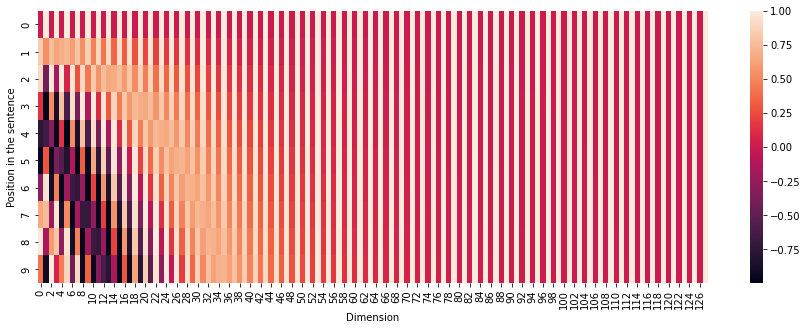

In [25]:
# let's assume we havee a sequence of length 10 and embedding of length 128
# how their positional encoding looks like

plt.figure(figsize=(15, 5))

# we define the positional encoding for a 128-dimensional vector and for this 
# example we do not use dropout
pe = PositionalEncoding(128, 0)

# note here we are assuming our input to be
# batch_size x sequence_length x d_model
# but in pytorch they are assuming 
# sequence_length x batch_size x d_model
# we also assume zeros so we can see how the positional encoding looks like
x_inputs = torch.zeros(1, 10, 128)
y = pe(x_inputs)

sns.heatmap(y.squeeze(0))
plt.xlabel('Dimension')
plt.ylabel('Position in the sentence')
plt.show()

# in the figure below each row corresponds to the vector we are adding 
# to our embedding vector when the word is at that position in the sentence

## Attention mechanism

The concept of attention is not completely new. It was already introduced for RNN and LSTM. We will start by briefly explain the attention mechanism and then we will go through the Multi-Head Self Attention that was used in the paper.

If we look at the difinition they used in the paper, we get that "An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key." 

The attention mechanism we are going to use is called "Scaled Dot-Product Attention" and it is shown in this Figure:

![Scaled Dot-Product Attention](attention.png)

By still using the description used in the paper, they say that "The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values."

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V . We compute the matrix of outputs as:

$$\text{Attention}(Q,K,V) = \text{softmax}{\left( \frac{QK^T}{\sqrt{d_k}} \right)}V$$

One of the main challenges I had in the past days, was to understand what this $Q,K,V$ actually are and how we can compute them. I've found this [video](https://www.youtube.com/watch?v=8zAP2qWAsKg&t=2071s) super useful (Here you can access the [slides](https://storage.googleapis.com/deepmind-media/UCLxDeepMind_2020/L7%20-%20UCLxDeepMind%20DL2020.pdf)). I really invite you to watch it if you want to understand a bit better how this is compute. I will show one slide here and try to writwe my understanding (to be confirmed if they are correct though, I am sorry). I will try to report the main slides here and comment this.

![Attention first step](slide_attention1.png)

By looking at the slide above, we compute $Q,K,V$ by using the embedding we get after using the word embedding and the positional encoding. We compute this for each world (in the image above we are in the encoder and we can access both previous and future words, in the decoder part we have to access only the previous words). We will use our generated query $q$ we just computed for the dot product of our query with all the key vectors of the considered words in the considered sequence and then apply softmax. In our example this corresponds to creating $\lambda_1, \lambda_2, \lambda_3, \lambda_4$. 

![Attention second step](slide2.png)

Then we will use these $\lambda$s to weight the value of the considered word ('beeetle' in this case) and create the new representation for our word a weighted sum that takes into account the context where our word is inserted. 

![Attention last step](slide4.png)


Now the Multi-Head Self Attention, which is represented in the next figure, is just a repeated computation of th eattention mechanism that we have just presented several times (in the figure below we are computing it $h$ times).

![Multi-Head Attention](multi_head_attention.png)

Here we show in a code snippet how you can implement from scratch this mechanism.

In [26]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [27]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

## Let's see how we can program this model in Pytorch

Now that we have a better understanding (hopefully) of the different components, we can show how we can program in very few lines of PyTorch. We will use this model to translate from German to English. This tutorial is taken from the [PyTorch website](https://pytorch.org/tutorials/beginner/translation_transformer.html). 

**Note:** one of the most challenging things (that I still have to figure out, so I am already apologizing if I won't be able to answer your questions) is all the data preprocess and how the data is fed to the model for training. I am still figuring that out.

In [32]:
%matplotlib inline

# packages we need for english and german vocabulary
!python -m pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.2.0/en_core_web_sm-3.2.0-py3-none-any.whl (13.9 MB)


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
  Using cached https://github.com/explosion/spacy-models/releases/download/de_core_news_sm-3.2.0/de_core_news_sm-3.2.0-py3-none-any.whl (19.1 MB)
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


### Data preprocessing 

In the following we are using `torchtext` library, which has utilities for creating datasets that can be easily iterated through for the purposes of creating a language translation model. In this example, we show how to use torchtext's inbuilt datasets, tokenize a raw text sentence, build vocabulary, and numericalize tokens into tensor. We will use Multi30k dataset, which contains different image captions from German to English. 

In [33]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List


SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# Create source and target language tokenizer. Make sure to install the dependencies.
# pip install -U spacy
# python -m spacy download en_core_web_sm
# python -m spacy download de_core_news_sm
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator 
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

100%|███████████████████████████████████████| 1.21M/1.21M [00:01<00:00, 861kB/s]


## Seq2Seq Network using Transformer

Below, we will create a Seq2Seq network that uses Transformer. The network consists of three parts. First part is the embedding layer. This layer converts tensor of input indices into corresponding tensor of input embeddings. These embedding are further augmented with positional encodings to provide position information of input tokens to the model. The second part is the actual Transformer model. Finally, the output of Transformer model is passed through linear layer that give un-normalized probabilities for each token in the target language.

You can notice that the PositionalEncoding and the TokenEmbedding are the same as the one we have analyzed above.

In [34]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network 
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

During training, we need a subsequent word mask that will prevent model to look into the future words when making predictions. We will also need masks to hide source and target padding tokens. Below, let's define a function that will take care of both.

In [35]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Let's now define the parameters of our model and instantiate the same. Below, we also 
define our loss function which is the cross-entropy loss and the optmizer used for training.

In [56]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, 
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)


print('Double checking the structure of our model')
print(transformer)

# initialization using xavier uniform
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_feature

## Collation

We need to convert these string pairs into the batched tensors that can be processed by our Seq2Seq network defined previously. Below we define our collate function that convert batch of raw strings into batch tensors that can be fed directly into our model.

In [37]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
# BOS = Beginning of sentence
# EOS = End of sentence
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Let's define training and evaluation loop that will be called for each 
epoch.



In [38]:
from torch.utils.data import DataLoader

# This function define all the operation needed to train our model for one epoch
def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


#function to evaluate the model on the validation set
def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

### Loading pre-trained model
Training this model will takes ~20mins. Therefore we are providing you some already trained weigths. You can find them here: https://drive.google.com/drive/folders/1gyBwlT1G2XnnoUyCDK4ndZZq9AFh_m4C. You should download them and them drag them into colab. How can you do that? On the left side of colab session there is a folder icon. Press that, you should see one folder called "sample data". Then you can drag the weights in the same space (be careful: you should **not** drag them into the "sample data" folder)

In [44]:
from timeit import default_timer as timer
NUM_EPOCHS = 18

already_trained = True

if already_trained:
    if DEVICE.type == 'cpu':
        transformer.load_state_dict(torch.load('transformer_weights.pt', map_location=torch.device('cpu')))
        print('Weights loaded')
    else:
        transformer.load_state_dict(torch.load('transformer_weights.pt'))
        print('Weights loaded')
else:
    best_val_error = 100
    for epoch in range(1, NUM_EPOCHS+1):
        start_time = timer()
        train_loss = train_epoch(transformer, optimizer)
        end_time = timer()
        val_loss = evaluate(transformer)
        print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
        if val_loss < best_val_error:
            print(f'Better val error in epoch {epoch}')
            torch.save(transformer.state_dict(), 'transformer_weigths.pt')


# function to generate output sequence using greedy algorithm 
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

Weights loaded


In [50]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))

 A group of people stand in front of an office store . 


In [46]:
print(translate(transformer, "Das Auto ist rot ."))

 The car is red . 


In [47]:
print(translate(transformer, "Eine Stadt auf dem Land ."))

 A city in the country . 


In [48]:
print(translate(transformer, "Ein Mann ist mit einem Hund ."))

 A man is in a dog . 


In [49]:
print(translate(transformer, "Eine Vase mit Blumen steht auf dem Tisch ."))

 A lot of flowers is standing on the table . 


In [52]:
print(translate(transformer, "Ein Auto fährt auf der Autobahn ."))

 A car is driving on the highway . 


In [53]:
print(translate(transformer, "Die Spieler jubeln nach dem Tor ."))

 The players are cheering for the goal . 


### Additional reference

Here I leave some references that can be used for understanding a bit better this complicated model (most of them I already linked while explaining some stuff):
- [Video from the main author of the paper](https://www.youtube.com/watch?v=rBCqOTEfxvg&t=894s)
- [Video lecture from Deepmind](https://www.youtube.com/watch?v=8zAP2qWAsKg&t=2073s)
- [Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
- [Blog Post on the Positional Encoder](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)
- [Transformer from Scratch](https://e2eml.school/transformers.html#positional_encoding)
- [Another blog post explaining transformer](https://jalammar.github.io/illustrated-transformer/)